In [104]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os

from skforecast.model_selection import random_search_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor

In [105]:
data = pd.DataFrame(columns=['date', 'indice'])

diretorio = '../data/rl/'

arquivos_json = [arquivo for arquivo in os.listdir(diretorio) if arquivo.endswith('.json')]

for arquivo_json in arquivos_json:
    with open(os.path.join(diretorio, arquivo_json), 'r') as file:
        d = json.loads(file.read())
        
        data_temp = pd.DataFrame({
            'date': d['Indices']['NDVI']['Serie Processada']['Data'],
            'indice': d['Indices']['NDVI']['Serie Processada']['Indice']
        })

        data = pd.concat([data, data_temp], ignore_index=True)

In [106]:
data

,date,indice
0,2017-07-28,0.000657
1,2017-11-01,0.000000
2,2017-11-09,0.017062
3,2017-11-17,0.008105
4,2017-12-11,0.010585
...,...,...
131,2020-03-29,0.018291
132,2020-04-14,0.092785
133,2020-06-09,0.034286
134,2020-07-03,0.021134


In [107]:
data.dtypes

date       object
indice    float64
dtype: object

In [108]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

In [109]:
data = data.set_index('date')
data = data.groupby(data.index).mean()
data = data.asfreq("M",method='backfill')
data = data.sort_index()
data

,indice
date,
2017-07-31,0.009194
2017-08-31,0.000717
2017-09-30,0.018780
2017-10-31,0.000315
2017-11-30,0.017883
2017-12-31,0.088264
2018-01-31,0.011017
2018-02-28,0.008140
2018-03-31,0.007450


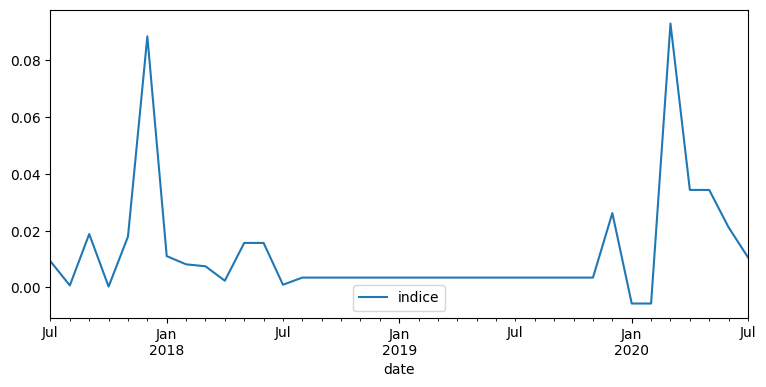

In [110]:
fig, ax = plt.subplots(figsize=(9, 4))
data['indice'].plot(ax=ax, label='indice')
ax.legend()

Model validation    

Train dates : 2017-07-31 00:00:00 --- 2020-04-30 00:00:00  (n=34)
Test dates  : 2020-05-31 00:00:00 --- 2020-07-31 00:00:00  (n=3)


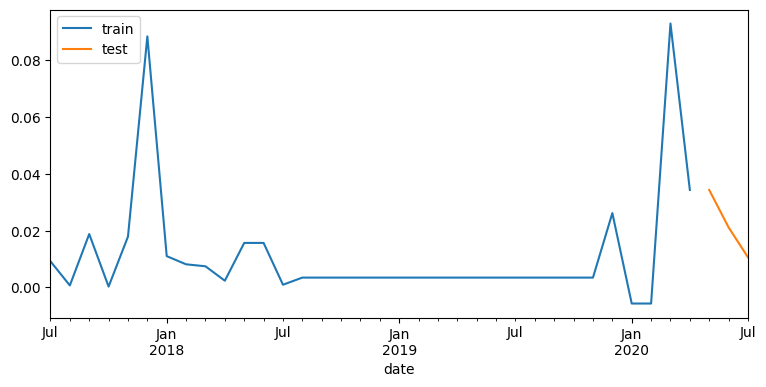

In [111]:
steps = 3

data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

# Plotando os dados
fig, ax=plt.subplots(figsize=(9, 4))
data_train['indice'].plot(ax=ax, label='train')
data_test['indice'].plot(ax=ax, label='test')
ax.legend();

In [112]:
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 10 # O valor será substituído durante o tunning
             )

# Valores de lag a testar
lags_grid = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Regressor hyperparameters
param_distributions = {'n_estimators': np.arange(start=10, stop=100, step=1, dtype=int),
                       'max_depth': np.arange(start=5, stop=30, step=1, dtype=int)}

results = random_search_forecaster(
              forecaster           = forecaster,
              y                    = data['indice'],
              steps                = steps,
              lags_grid            = lags_grid,
              param_distributions  = param_distributions,
              n_iter               = 100,
              metric               = 'mean_squared_error',
              refit                = True,
              initial_train_size   = len(data['indice']) - steps,
              fixed_train_size     = False,
              return_best          = True,
              random_state         = 123,
              verbose              = False
          )

results

Number of models compared: 900.


lags grid: 100%|██████████| 9/9 [01:07<00:00,  7.47s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'n_estimators': 74, 'max_depth': 13}
  Backtesting metric: 0.00020381449511824856



,lags,params,mean_squared_error,n_estimators,max_depth
285,"[1, 2, 3, 4]","{'n_estimators': 74, 'max_depth': 13}",0.000204,74,13
283,"[1, 2, 3, 4]","{'n_estimators': 74, 'max_depth': 19}",0.000204,74,19
295,"[1, 2, 3, 4]","{'n_estimators': 75, 'max_depth': 23}",0.000205,75,23
245,"[1, 2, 3, 4]","{'n_estimators': 75, 'max_depth': 27}",0.000205,75,27
256,"[1, 2, 3, 4]","{'n_estimators': 73, 'max_depth': 7}",0.000205,73,7
...,...,...,...,...,...
704,"[1, 2, 3, 4, 5, 6, 7, 8, 9]","{'n_estimators': 83, 'max_depth': 27}",0.000939,83,27
773,"[1, 2, 3, 4, 5, 6, 7, 8, 9]","{'n_estimators': 81, 'max_depth': 24}",0.000945,81,24
717,"[1, 2, 3, 4, 5, 6, 7, 8, 9]","{'n_estimators': 79, 'max_depth': 9}",0.000947,79,9
788,"[1, 2, 3, 4, 5, 6, 7, 8, 9]","{'n_estimators': 95, 'max_depth': 22}",0.000950,95,22


In [113]:
# Configura e treina um RandomForestRegressor para série temporal
# Os parâmetros foram retirados do melhor modelo encontrado no material de origem
# Para conseguir os melhores parâmetros se faz necessário realizer hyperparameter tunning (verifique artigo original)
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(max_depth=25, n_estimators=10, random_state=123),
                lags      = 9
             )

forecaster.fit(y=data_train['indice'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=25, n_estimators=10, random_state=123) 
Lags: [1 2 3 4 5 6 7 8 9] 
Transformer for y: None 
Transformer for exog: None 
Window size: 9 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2017-07-31 00:00:00'), Timestamp('2020-04-30 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: M 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 25, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-11-01 21:50:32 
Last fit date: 2023-11-01 21:50:32 
Skforecast 

In [114]:
# Faz predição no conjunto de teste
predictions = forecaster.predict(steps=steps)
predictions

2020-05-31    0.007851
2020-06-30    0.043390
2020-07-31    0.035896
Freq: M, Name: pred, dtype: float64

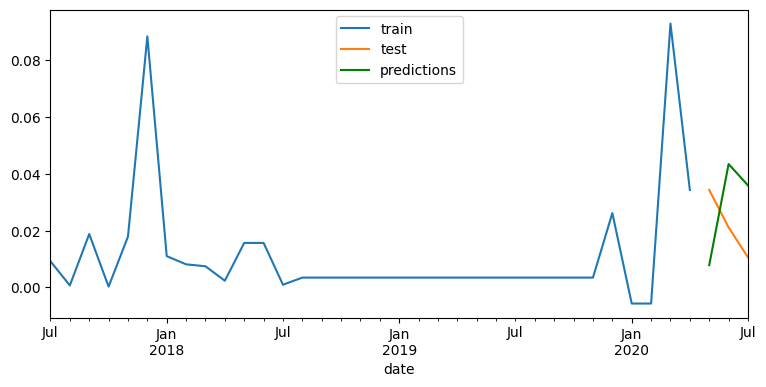

In [115]:
# Plota a predição, comparando com valores reais
fig, ax=plt.subplots(figsize=(9, 4))
data_train['indice'].plot(ax=ax, label='train')
data_test['indice'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions', color='green')
ax.legend();
# Aqui fica claro que o skforecast não fez um bom trabalho, mesmo com tunning

In [116]:
# Vamos tentar com o ARIMA
!pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable


In [117]:
# O ARIMA vem com um tunning automático, o auto_arima
from pmdarima.arima import auto_arima

model = auto_arima(data_train['indice'], trace=True, error_action='ignore', suppress_warnings=True)
# Treina o modelo
model.fit(data_train['indice'])
# Previsao
forecast = model.predict(n_periods=len(data_test))
# Converte para um dataframe
forecast = pd.DataFrame(forecast,index = data_test.index,columns=['Prediction'])
forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-157.762, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-161.196, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-159.598, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-159.778, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-154.394, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.404 seconds


,Prediction
date,
2020-05-31,0.011587
2020-06-30,0.011587
2020-07-31,0.011587


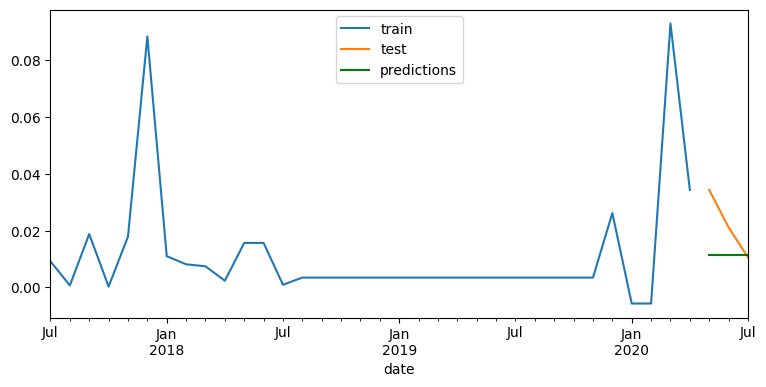

In [118]:
# Plota a predição, comparando com valores reais
fig, ax=plt.subplots(figsize=(9, 4))
data_train['indice'].plot(ax=ax, label='train')
data_test['indice'].plot(ax=ax, label='test')
forecast['Prediction'].plot(ax=ax, label='predictions', color='green')
ax.legend();

In [119]:
import pandas as pd
import numpy as np

# Criar dados sintéticos em duas colunas diferentes
np.random.seed(42)
data_length = 10
coluna1 = np.random.rand(data_length)

# Criar um DataFrame com as colunas e nomes específicos
df = pd.DataFrame({'Coluna': coluna1})

# Criar um índice com datas mensais a partir de uma data inicial
start_date = '2018-10-31'
date_rng = pd.date_range(start=start_date, periods=data_length, freq='M')

# Aplicar o índice ao DataFrame
df.index = date_rng

df = df.reset_index().rename(columns={'index':'date', 'Coluna': 'indice'})[['date', 'indice']].set_index('date')
# Aplique o modelo aos novos dados
forecast = model.predict(n_periods=len(df))
forecast_df = pd.DataFrame(forecast, index=df.index, columns=['Prediction'])

In [120]:
df = df.reset_index().rename(columns={'index':'date', 'Coluna': 'indice'})[['date', 'indice']].set_index('date')

In [121]:
# Aplique o modelo aos novos dados
forecast = model.predict(n_periods=len(df))
forecast_df = pd.DataFrame(forecast, index=df.index, columns=['Prediction'])

In [122]:
forecast_df

,Prediction
date,
2018-10-31,NaN
2018-11-30,NaN
2018-12-31,NaN
2019-01-31,NaN
2019-02-28,NaN
2019-03-31,NaN
2019-04-30,NaN
2019-05-31,NaN
2019-06-30,NaN


In [123]:
# Configura e treina um RandomForestRegressor para série temporal
# Os parâmetros foram retirados do melhor modelo encontrado no material de origem
# Para conseguir os melhores parâmetros se faz necessário realizer hyperparameter tunning (verifique artigo original)
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(max_depth=3, n_estimators=10, random_state=123),
                lags      = 9
             )

forecaster.fit(y=df['indice'])
forecaster

# Faz predição no conjunto de teste
predictions = forecaster.predict(steps=steps)
predictions

/workspace/.pyenv_mirror/user/current/lib/python3.10/site-packages/skforecast/utils/utils.py:788: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/workspace/.pyenv_mirror/user/current/lib/python3.10/site-packages/skforecast/utils/utils.py:788: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/workspace/.pyenv_mirror/user/current/lib/python3.10/site-packages/skforecast/utils/utils.py:850: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


9     0.708073
10    0.708073
11    0.708073
Name: pred, dtype: float64